# Predicting Uber Rider Retention
### Hongyang Fan
---
## I. Definition
---
### Project Overview

Uber is interested in predicting rider retention. It would be very helpful for them to know what factors are most important for rider retention. To help explore this problem, they have provided a sample [dataset](https://www.dropbox.com/s/q5e3lqtma9dwmy6/uber_data_challenge.json?dl=0) of 50,000 users who signed up for an Uber account in January 2014. 

In this binary prediction project, I will apply classification algorithms in Python to predict Uber rider retention and explore feature importance. Eventually, I will provide data-driven suggestions to operationalize those insights to help Uber.


### Problem Statement
I would consider predicting rider retention as a supervised binary classification problem. The ultimate goal of this project is to find an machine learning algorithm to predict current rider retention and optimize retention rate by finding important features.

In this project, I will consider a rider retained if he/she was “active” (i.e. took a trip) in the preceding 30 days. Because the data was pulled several months later, I assumed the current date is `"2014-07-01"` and a user retained if the `last_trip_date` is after `"2014-06-01"`.

- I will complete data cleaning to fill missing values, remove outliers and also preprocess dataset for algorithm implementation.
- In exploratory phase, I will check basic statistics and rider segregation and train a Logistic Regression model as a benchmark.
- As for modeling, I will try Decision Tree, Random Forest and Support Vector Machine (SVM) classifiers to see which performs best on my training set. I will choose one algorithm for further reach to tune the respective parameters. 
- Finally, I will validate my model by cross-validation or on test set. Also, I will check the feature importance in the final model to provide suggestions for Uber.

### Dataset description

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY­MM­DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY­MM­DD’ 
- avg_dist: the average distance *(in miles) per trip taken in the first 30 days after signup 
- avg_rating_by_driver: the rider’s average rating over all of their trips 
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips 
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips 
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- uber_black_user: TRUE if the user took an Uber Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

## II. Analysis
---
### Data Exploration

In [2]:
# Import modules

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load data

with open('train.json','r') as data_file:
    data = json.load(data_file)
df = pd.DataFrame(data)
df.shape

(50000, 12)

In [4]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


#### Basic Statistics

In [5]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [6]:
#### Missing values

In [7]:
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
uber_black_user              0
weekday_pct                  0
dtype: int64

In [8]:
df1 = df.copy()

In [9]:
# Fill missing values with median
df1['avg_rating_by_driver'].fillna(df1['avg_rating_by_driver'].median(), inplace = True)
df1['avg_rating_of_driver'].fillna(df1['avg_rating_of_driver'].median(), inplace = True)

# Drop all rows with missing values in 'phone'
df1 = df1.dropna().reset_index(drop = True)

# Doubel check missing values by column
df1.isnull().sum()

avg_dist                  0
avg_rating_by_driver      0
avg_rating_of_driver      0
avg_surge                 0
city                      0
last_trip_date            0
phone                     0
signup_date               0
surge_pct                 0
trips_in_first_30_days    0
uber_black_user           0
weekday_pct               0
dtype: int64

#### Outliers

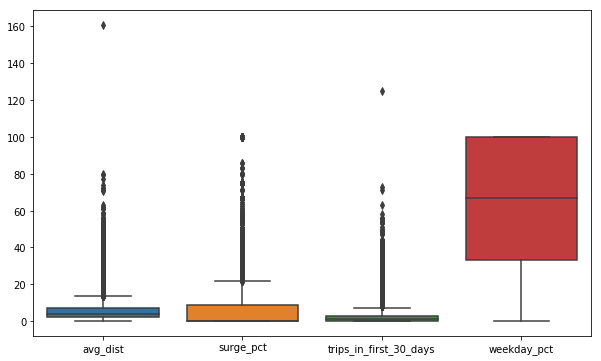

In [10]:
import seaborn as sns
%matplotlib inline

# Check outliers by boxplots
f, ax = plt.subplots(figsize=[10,6])
sns.boxplot(data=df1[['avg_dist','surge_pct','trips_in_first_30_days','weekday_pct']])


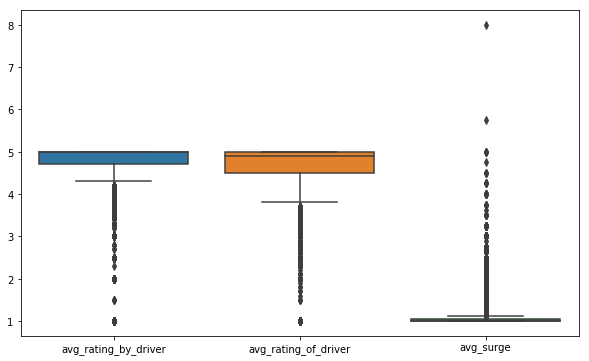

In [11]:
f, ax = plt.subplots(figsize=[10,6])
sns.boxplot(data=df1[['avg_rating_by_driver','avg_rating_of_driver','avg_surge']])

#### Count outliers by columns

In [12]:
from collections import defaultdict
outliers = defaultdict(lambda:0)

# for each feature find the data points with extreme high or low values
feature_pool = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

for feature in feature_pool:
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = df1[feature].quantile(0.25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = df1[feature].quantile(0.75)
    
    # Use the interquantile range to calculate an outlier step (1.5 times the interquantile range)
    interquantile = Q3 - Q1
    
    outliers_df = df1[(df1[feature] > (Q3 + 1.5 * interquantile)) | (df1[feature] < (Q1 - 1.5 * interquantile))]
    
    for index in outliers_df.index.values:
        outliers[index] += 1
    
    print('Outliers for %s : ' % feature, outliers_df.shape[0])

Outliers for avg_dist :  4477
Outliers for avg_rating_by_driver :  3922
Outliers for avg_rating_of_driver :  3106
Outliers for avg_surge :  8369
Outliers for surge_pct :  6768
Outliers for trips_in_first_30_days :  3153
Outliers for weekday_pct :  0


In [13]:
# Count outliers for more than one feature

outlier_list = [index for (index, count) in outliers.items() if count>1]
print('Number of outliers for more than one feature : %d' % len(outlier_list))

Number of outliers for more than one feature : 7805


In [14]:
# Remove the outliers for more than one feature
df1 = df1.drop(index=outlier_list).reset_index(drop=True)
df1.shape

(41799, 12)

#### Non-numerical variables

In [16]:
# Check unique values for categorical variables

print(df1['city'].value_counts())
print('\n')
print(df1['phone'].value_counts())

Winterfell        19838
Astapor           13619
King's Landing     8342
Name: city, dtype: int64


iPhone     28988
Android    12811
Name: phone, dtype: int64


In [18]:
# Check range of date column

print('signup_date: ', df1['signup_date'].min(), df1['signup_date'].max())
print('last_trip_date', df1['last_trip_date'].min(), df1['last_trip_date'].max())

signup_date:  2014-01-01 2014-01-31
last_trip_date 2014-01-01 2014-07-01


In [19]:
# Label predicted variable
# The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
# I would assume a user retained if the `last_trip_date` is after "2014-06-01" while assuming the current date is "2014-07-01".

df1['active'] = df1['last_trip_date'] >= '2014-06-01'

# Drop 'last_trip_date'
del df1['last_trip_date']

# What's the null error rate? what percentage retended?
df1['active'].mean()

0.37405201081365586

Only 37.6% riders retained, which means that I could obtain 62.4% accuracy by always predicting 'no'. So we are doing better than the null error rate, but not by much.

In [20]:
df1.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
uber_black_user              bool
weekday_pct               float64
active                       bool
dtype: object

### Exploratory Visualization
---
#### Pair Scatter Plot

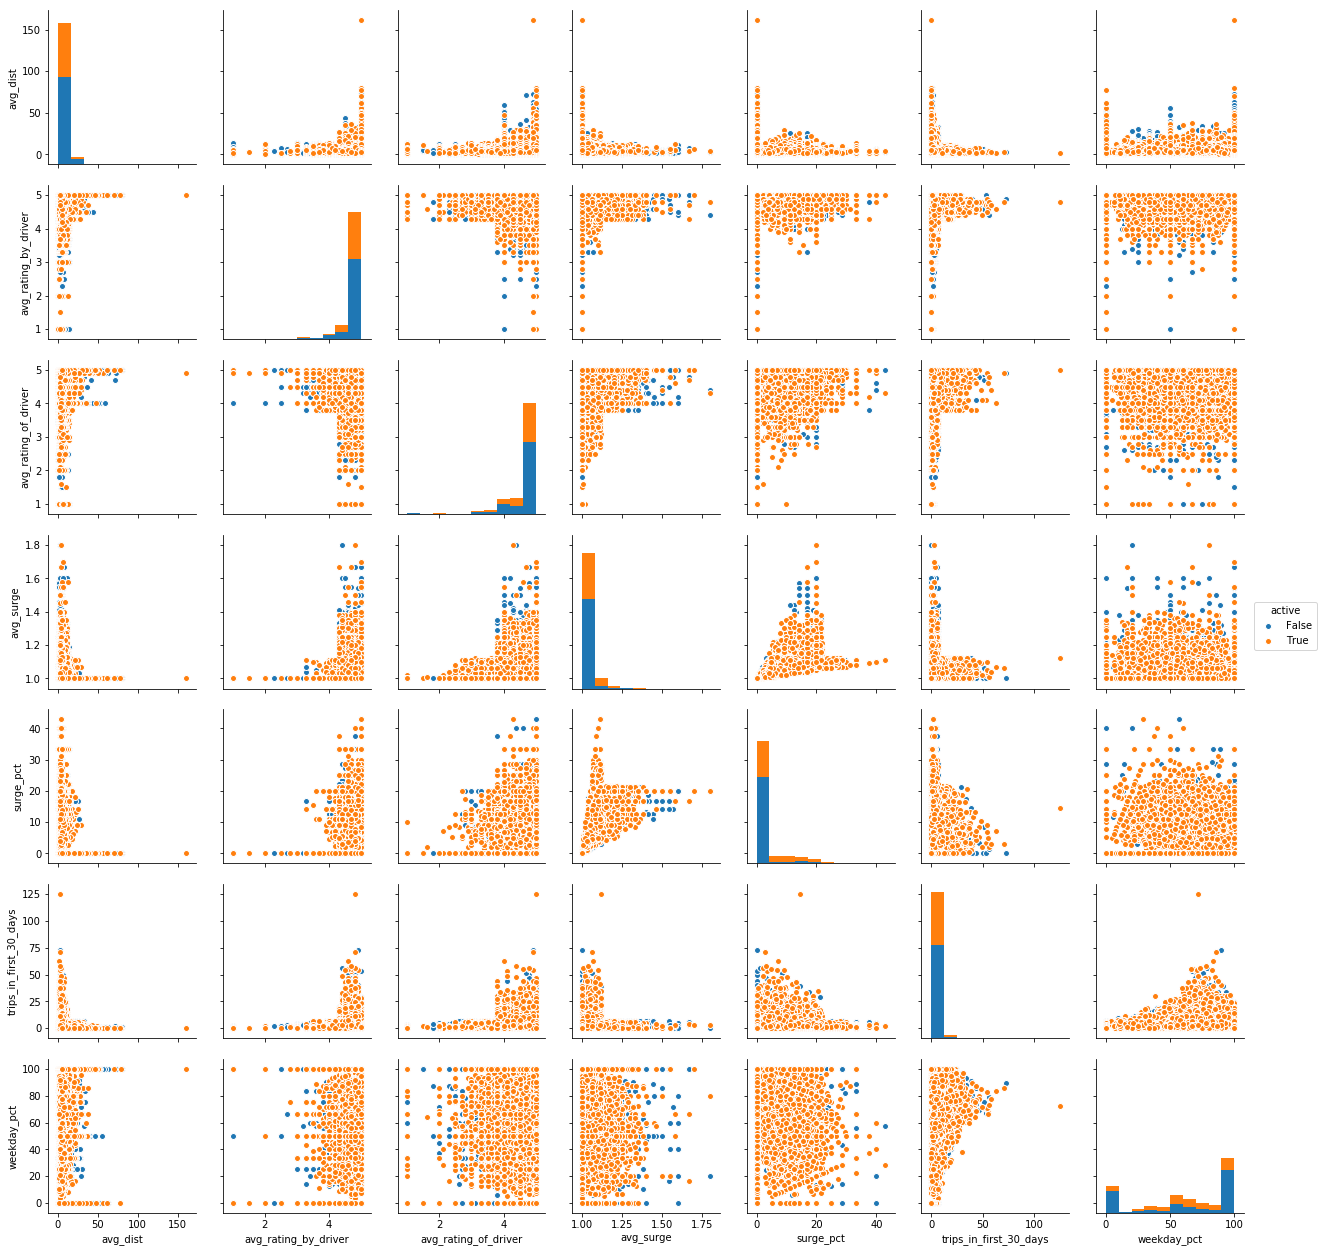

In [22]:
# Separate quantitative features and categorical features
quant_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct', 'active']

# Visualize pairwise relationships between quantitative features
sns.pairplot(df1[quant_features],
             hue='active',
             vars=['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']
            )

#### Correlation Matrix

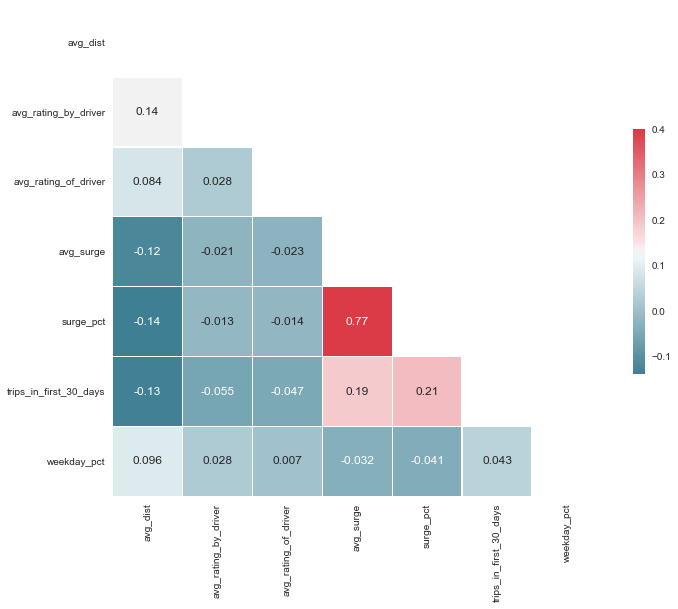

In [26]:
sns.set(style='white')

# Compute the correlation matrix
corr = df1[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.4, annot=True,
           square=True, linewidths=0.5, cbar_kws={'shrink':.5}, ax=ax)

#### Barplots for non-numerical features

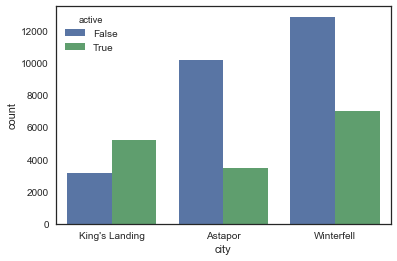

In [29]:
sns.countplot(x='city', hue='active',data=df1)

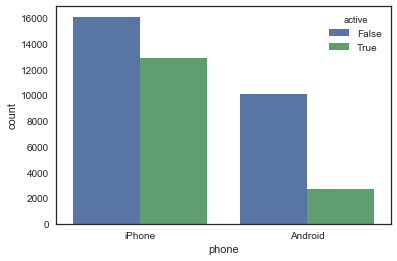

In [30]:
sns.countplot(x='phone', hue='active',data=df1)

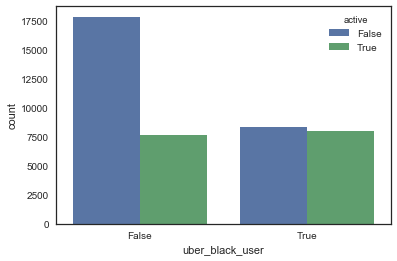

In [31]:
sns.countplot(x="uber_black_user", hue="active", data=df1)

## III. Methodology
---
### Define Performance Metric

In [32]:
from sklearn.metrics import roc_auc_score

def performance_metric(y_true, y_predict):
    score = roc_auc_score(y_true, y_predict)
    return score

### Data Preprocessing

In [34]:
from sklearn import preprocessing

# Encode all non-numerical features
le = preprocessing.LabelEncoder()
df1['city'] = le.fit_transform(df1['city'])
df1['phone'] = le.fit_transform(df1['phone'])
df1['signup_date'] = le.fit_transform(df1['signup_date'])

df1.dtypes


avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                        int64
phone                       int64
signup_date                 int64
surge_pct                 float64
trips_in_first_30_days      int64
uber_black_user              bool
weekday_pct               float64
active                       bool
dtype: object

In [35]:
df1.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.1,1,1,24,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.0,0,0,28,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.0,0,1,5,0.0,3,False,100.0,False
3,10.56,5.0,3.5,1.0,2,1,8,0.0,2,True,100.0,True
4,3.95,4.0,4.9,1.0,0,0,23,0.0,1,False,100.0,False


#### Shuffle and split data into training and test sets

In [36]:
from sklearn.cross_validation import train_test_split

y = df1['active']
X = df1.drop('active',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Benchmark

In [37]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model
lm = LogisticRegression()

# Train the model
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
# check the model accuracy by AUC score on the test set
print(performance_metric(y_train, lm.predict(X_train)))
print(performance_metric(y_test, lm.predict(X_test)))

0.6504854595419278
0.6543385566633103


### Implementation

In [44]:
# Import the three supervised learning algorithm from sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Initialize the three models
clf_knn = KNeighborsClassifier()
clf_svc = SVC()
clf_rf = RandomForestClassifier()

# Loop through models, then return respective AUC score
for clf in [clf_knn, clf_svc, clf_rf]:
    print('\n%s : ' % clf.__class__.__name__)
    clf.fit(X_train, y_train)
    print(performance_metric(y_train, clf.predict(X_train)))
    print(performance_metric(y_test, clf.predict(X_test)))


KNeighborsClassifier : 
0.7802277581601694
0.697244988207507

SVC : 
0.792745886852079
0.7120269384688486

RandomForestClassifier : 
0.9764146660354897
0.722858670988399


Base on my earlier experiments, `RandomForestClassifier` performs best on test data among all other algorithms. I would choose Random Forest for further optimization.

### Refinement

In [47]:
# Import 'GridSearchCV' and 'make_scorer'

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.cross_validation import ShuffleSplit

def fit_model(X,y):
    '''
    Performs grid search over the 'max_depth' parameter for a 
    random forest classifier trained on the input data [X,y]
    '''
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.3, random_state=1)
    
    # Create a random forest classifier object
    clf = RandomForestClassifier(random_state=1)
    
    # Create a dictionary for the parameter 'max_features' and 'max_depth'
    parameters = {
        'max_features':[1,2,3,4,5,6,7,8,9,10,11],
        'max_depth':[1,2,3,4,5,6,7,8,9,10],
#        'n_estimator':[10,20,30,40,50,60,70,80,90,100] # too slow to implement
        }
    
    # Transform 'performance metric' into a scoring function using 'make_scorer'
    scoring_func = make_scorer(performance_metric)
    
    # Create the grid search object
    grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scoring_func, cv=cv_sets)
    
    # Fit the grid search object to the data to compute the optimal model
    grid_obj = grid_obj.fit(X,y)
    
    # Return the optimal model after fitting the data
    return grid_obj.best_estimator_

In [48]:
# Fit the training data to the model using grid search
clf = fit_model(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

In [49]:
print('Tuned model has a training AUROC score of %.4f' % performance_metric(y_train, y_train_predict))
print('Tuned model has a test AUROC score of %.4f' % performance_metric(y_test, y_test_predict))
print("Parameter 'max_features' is %d for the optimal model." % clf.get_params()['max_features'])
print("Parameter 'max_depth' is %d for the optimal model." % clf.get_params()['max_depth'])
#print "Parameter 'n_estimators' is {} for the optimal model.".format(clf.get_params()['n_estimators'])

Tuned model has a training AUROC score of 0.7693
Tuned model has a test AUROC score of 0.7564
Parameter 'max_features' is 10 for the optimal model.
Parameter 'max_depth' is 8 for the optimal model.


In [50]:
# Change 'n_estimators' to 100
clf = RandomForestClassifier(n_estimators=100, max_depth=8, max_features=10, random_state=1)
clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

print('Tuned model has a training AUROC score of %.4f' % performance_metric(y_train, y_train_predict))
print('Tuned model has a test AUROC score of %.4f' % performance_metric(y_test, y_test_predict))

Tuned model has a training AUROC score of 0.7713
Tuned model has a test AUROC score of 0.7571


## IV. Results
---
### Model Evaluation and Validation

In [52]:
import sklearn.learning_curve as curves

def plt_max_features(X,y):
    '''
    Calculate the performance of the model as model complexity increases.
    The learning and testing error rates are then plottted
    '''
    
    # Create 10 cross-validation sets for the training and testing
    cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.3, random_state=1)
    
    # Vary the max_features parameter from 1 to 11
    features_range = np.arange(1,12)
    
    # Create a Random Forest classifier at optimal settings
    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=1)
    
    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(clf, X, y, param_name='max_features', 
                                                        param_range=features_range, cv=cv, scoring='roc_auc')
    
    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot the validation curve
    plt.figure(figsize=(7,5))
    plt.title('Random Forest Classifier Complexity Performance')
    plt.plot(features_range, train_mean, 'o-', color='r', label='Traning Score')
    plt.plot(features_range, test_mean, 'o-', color='g', label='Test Score')
    plt.fill_between(features_range, train_mean-train_std, train_mean+train_std, alpha=0.15, color='r')
    plt.fill_between(features_range, test_mean-test_std, test_mean+test_std, alpha=0.15, color='r')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Features')
    plt.ylabel('AUROC Score')
    plt.ylim([0.83,0.88])
    plt.show()
    
def plt_max_depth(X,y):
    '''
    Calculate the performance of the model as model complexity increases.
    The learning and testing error rates are then plottted
    '''
    
    # Create 10 cross-validation sets for the training and testing
    cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.3, random_state=1)
    
    # Vary the max_depth parameter from 1 to 10
    depth_range = np.arange(1,11)
    
    # Create a Random Forest classifier at optimal settings
    clf = RandomForestClassifier(max_features=10, n_estimators=100, random_state=1)
    
    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(clf, X, y, param_name='max_depth', 
                                                        param_range=depth_range, cv=cv, scoring='roc_auc')
    
    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot the validation curve
    plt.figure(figsize=(7,5))
    plt.title('Random Forest Classifier Complexity Performance')
    plt.plot(depth_range, train_mean, 'o-', color='r', label='Traning Score')
    plt.plot(depth_range, test_mean, 'o-', color='g', label='Test Score')
    plt.fill_between(depth_range, train_mean-train_std, train_mean+train_std, alpha=0.15, color='r')
    plt.fill_between(depth_range, test_mean-test_std, test_mean+test_std, alpha=0.15, color='r')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('AUROC Score')
    plt.ylim([0.60,0.95])
    plt.show()

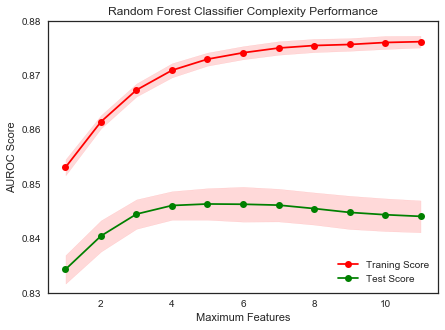

In [53]:
plt_max_features(X_train, y_train)

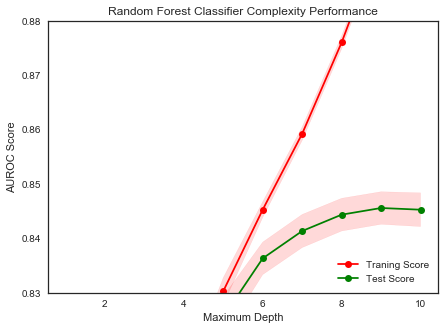

In [54]:
plt_max_depth(X_train, y_train)

In [55]:
clf = RandomForestClassifier(max_features=4, max_depth=9, n_estimators=100, random_state=1)
clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

print('Tuned model has a training AUROC score of %.4f' % performance_metric(y_train, y_train_predict))
print('Tuned model has a test AUROC score of %.4f' % performance_metric(y_test, y_test_predict))

Tuned model has a training AUROC score of 0.7734
Tuned model has a test AUROC score of 0.7512


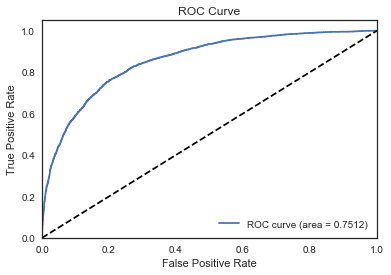

In [57]:
%matplotlib inline

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, clf.predict(X_test))

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## V. Conclusion
---
### Feature Importance

In [60]:
clf.feature_importances_

array([0.05029959, 0.16405824, 0.02641261, 0.12757376, 0.11635375,
       0.07394959, 0.02635838, 0.19324943, 0.06198913, 0.0485246 ,
       0.11123092])

Feature ranking: 
                         0         1
7                surge_pct  0.193249
1     avg_rating_by_driver  0.164058
3                avg_surge  0.127574
4                     city  0.116354
10             weekday_pct  0.111231
5                    phone  0.073950
8   trips_in_first_30_days  0.061989
0                 avg_dist  0.050300
9          uber_black_user  0.048525
2     avg_rating_of_driver  0.026413
6              signup_date  0.026358


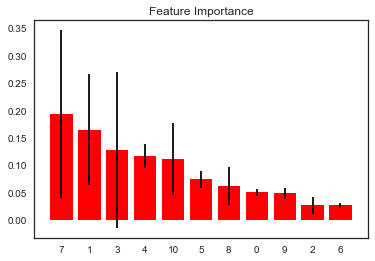

In [63]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking: ')

# Check feature importance
importances_df = pd.DataFrame(list(zip(X_train.columns, np.transpose(clf.feature_importances_)))).sort_values([1], ascending=False)
print(importances_df)

# Plot the feature importance of the forest
plt.figure()
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()